# Fraud detection with Benford's law

Benford's law is the empirical observation that the distribution of the first digit of numbers, in a wide variety of cases, is not uniform and has follows a specific distribution.

This law is sometimes use in audits to detect frauds, inefficiencies, and other irregularities in accounting books.

In this demo, we would like to apply this method to the expenses made on their Personal Cards by employees of the City of Westminster council in the month of January, 2014.

In [1]:
# Initialize inline plots
%matplotlib inline

# Useful imports
import os.path
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Load the data in a Pandas DataFrams.
filename = os.path.join('data', 'City_of_Westminster_Council_line_level_data_Jan2014_PCARD.csv')
expenses = pd.read_csv(filename)

In [3]:
# Look at a sample of the data.
expenses.head()

,Body Name,Date,Transaction Number,Amount,Supplier,Expense Area,Directorate Name,Cost Centre Name,Subjective,Supplier Size,Merchant Category Code,Merchant Category Label
0,City of Westminster Council,01/01/2014,SCC:PCA:8004,1.69,BOOTS,Libraries & Culture,NaN,Unknown PCARD Cost Centre,Unknown PCARD Subjective,NaN,NaN,NaN
1,City of Westminster Council,01/01/2014,SCC:PCA:8005,7.98,CHIC NEWS,Adult Services,NaN,Unknown PCARD Cost Centre,Unknown PCARD Subjective,NaN,NaN,NaN
2,City of Westminster Council,01/01/2014,SCC:PCA:8006,336.60,ENVIRO WASTE LONDON LT,Adult Services,NaN,Unknown PCARD Cost Centre,Unknown PCARD Subjective,NaN,NaN,NaN
3,City of Westminster Council,01/01/2014,SCC:PCA:8007,36.40,GREATER ANGLIA T/O,Childrens Services,NaN,Unknown PCARD Cost Centre,Unknown PCARD Subjective,NaN,V000000549,Rail Companies
4,City of Westminster Council,01/01/2014,SCC:PCA:8007,83.10,GREATER ANGLIA T/O,Childrens Services,NaN,Unknown PCARD Cost Centre,Unknown PCARD Subjective,NaN,V000000549,Rail Companies


In [4]:
expenses.Amount.describe()

count    1294.000000
mean       50.486352
std       127.273646
min      -330.000000
25%         5.740000
50%        14.220000
75%        40.000000
max      2610.000000
Name: Amount, dtype: float64

The data set contains small expenses, up to a maximum of 2610 GBP.

The minimum amount is negative, which means that the data sets contains reimbursement, which we do not want to consider further.

In [5]:
# Remove reimbursements and numbers that start with '0'.
invalid = expenses.Amount <= 1.0
expenses.loc[invalid, 'Amount'] = np.nan

In [6]:
# Extract first digit.
def get_first_digit(x):
    """ Return the first digit of a floating point number. """
    if np.isnan(x):
        return x
    digit = str(x)[0]
    return int(digit)

expenses['digit'] = expenses.Amount.apply(get_first_digit)

In [7]:
expenses.digit

0     1
1     7
2     3
3     3
4     8
5     1
6     2
7     1
8     2
9     8
10    5
11    9
12    5
13    1
14    4
...
1279   NaN
1280     1
1281     6
1282     2
1283     1
1284     4
1285     3
1286     5
1287     4
1288     2
1289     2
1290     4
1291     4
1292     1
1293     1
Name: digit, Length: 1294, dtype: float64

In [8]:
# Counts of first digits.
counts = expenses.groupby('digit').Amount.count()
print counts

digit
1        325
2        207
3        144
4        161
5        174
6         76
7         54
8         75
9         46
Name: Amount, dtype: int64


Now we need to compare the distribution of the first digit in the reported expenses with the one predicted by Benford's law.

In [9]:
# Benford's distribution.
digits = np.arange(1, 10)
p = np.log10(1.0 + 1.0/digits)
predicted_counts = p * counts.sum()

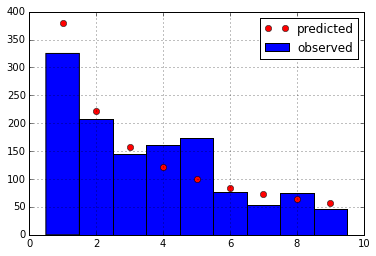

In [10]:
# Compare to Benford's law prediction, visually.
expenses.digit.hist(bins=np.arange(1, 11) - 0.5)
plt.plot(digits, predicted_counts, 'ro')
plt.legend(['predicted', 'observed']);

There is a suspicious excess of digits '4' and '5'... is it a statistically significant observation?

To verify this, we would like to test the null hypothesis that the two distributions are identical.

In [11]:
stat, p_value = stats.chisquare(counts, predicted_counts)
print 'Chi-squared=%.2f, P=%.6f' % (stat, p_value)

Chi-squared=87.28, P=0.000000


The test indicates that it's incredibly unlikely that the two distributions are identical. What causes the deviation from Benford's law?

Let's have a look at all the transactions starting with digit '5'.

In [12]:
suspicious = expenses[expenses.digit == 5][['Amount', 'Supplier']]
pd.set_option('display.max_rows', 500)
suspicious

,Amount,Supplier
10,5.15,Photobox Limited
12,5.00,TESCO CONVENIENCE
24,5.45,MARKS & SPENCER SSPLTD
38,5.78,EAT
44,52.70,LUL TICKET MACHINE
63,500.00,QUEENS HOTEL
69,5.60,SOUTHBANK CENTRE
70,5.47,TESCO STORE
74,5.00,THE PEN SHOP
89,50.00,HOBBS


Is it possible that the anomalies are due to recurrent expenses with the same amount?

We can have a look at the distribution of suppliers for expenses that start with '5'.

In [13]:
g = suspicious.groupby('Supplier')
count = g.count()
count.sort('Amount').tail()

,Amount
Supplier,
TESCO STORE,8
PRET A MANGER,8
SUBWAY,9
OYSTER RENEW WEB,10
LUL TICKET MACHINE,27


It looks like most of these transactions are due to London Underground charges of 5.00 and 50.0 pounds ('OYSTER RENEW WEB' and 'LUL TICKET MACHINE').

In fact, looking at the distribution of amounts it's possible to see that prices in this cluster around round numbers: 5, 10, 20, etc.

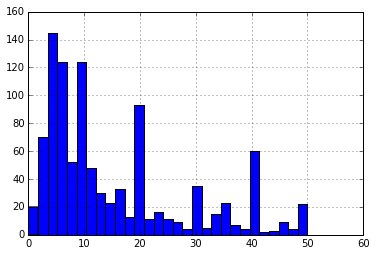

In [14]:
expenses.Amount.hist(bins=np.linspace(0, 50, 30));

In this particular case, Benford's law is foiled by the behavioral psychology behind retail prices.

The analysis does point out some inefficiencies: multiple entries with the same amount and supplier indicate that the City of Westminster could save money by making this purchases in bulk; for example, by negotiating a collective price for the London Underground season ticket for its employees.

If you want to know more about Benford's law and its use in fraud detection, here are a few references:
* “The scam buster”, The Economist, Dec 15 2012
* “I’ve got your number”, Journal of accountancy, May 1999
* “The first digit phenomenon”, T.Hill, 1998
* “A statistical derivation of the significant-digit law”, T.Hill, Statistical Science 1996